In [2]:
import numpy as np 
import pandas as pd
import datetime as dt
import math


# 시각화 모듈
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터 전처리 모듈
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import  StandardScaler,MinMaxScaler
from sklearn.model_selection import StratifiedShuffleSplit


# 데이터 모델링 모듈
from sklearn.ensemble import RandomForestClassifier 
from xgboost import XGBClassifier

# 교차검증 모듈
import optuna

# 데이터 모델 평가 모듈
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# sleep_score

## origin
- 교차검증 정확도 95.6/ 테스트 정확도 95.7

### 데이터 로드 및 전처리

In [17]:
data=pd.read_csv('2020_2th_paper_data_plus_activity_v2.csv')

# lastupdate관련 컬럼 및  height, weight, bmi 컬럼 삭제 
data.drop(['Unnamed: 0','height_double','bmi','weight','height'],axis=1, inplace=True)
data=data.drop(['lastUpdate_month_8', 'lastUpdate_month_9', 'lastUpdate_month_10', 
'lastUpdate_weekend_0', 'lastUpdate_weekend_1', 'lastUpdate_weekend_2',
'lastUpdate_weekend_3', 'lastUpdate_weekend_4', 'lastUpdate_weekend_5', 'lastUpdate_weekend_6',
'lastUpdate_day_1', 'lastUpdate_day_2', 'lastUpdate_day_3', 'lastUpdate_day_4', 'lastUpdate_day_5',
'lastUpdate_day_6', 'lastUpdate_day_7', 'lastUpdate_day_8', 'lastUpdate_day_9', 'lastUpdate_day_10',
'lastUpdate_day_11', 'lastUpdate_day_12', 'lastUpdate_day_13', 'lastUpdate_day_14', 'lastUpdate_day_15',
'lastUpdate_day_16', 'lastUpdate_day_17', 'lastUpdate_day_18', 'lastUpdate_day_19', 'lastUpdate_day_20',
'lastUpdate_day_21', 'lastUpdate_day_22', 'lastUpdate_day_23', 'lastUpdate_day_24', 'lastUpdate_day_25',
'lastUpdate_day_26', 'lastUpdate_day_27', 'lastUpdate_day_28', 'lastUpdate_day_29', 'lastUpdate_day_30',
'lastUpdate_day_31'],axis=1)

# 최종 예측변수 생성
data['sleep_classes'] = data['sleep_score'].apply(lambda x: 1 if x>=55 else 0)
data.head()

,userId,date,sleep,amCondition,amEmotion,pmEmotion,pmStress,pmFatigue,cAmount(ml),aAmount(ml),...,761,762,763,764,791,792,793,91,92,sleep_classes
0,user01,2020-08-30,3.0,3.0,3.0,4.0,2.0,4.0,-1.0,-1.0,...,0,0,0,0,0,0,1,0,0,1
1,user01,2020-08-31,2.0,2.0,3.0,4.0,3.0,2.0,250.0,-1.0,...,0,0,0,0,0,0,1,0,0,1
2,user01,2020-09-07,4.0,3.0,4.0,4.0,4.0,2.0,500.0,-1.0,...,0,0,0,0,0,0,1,0,0,1
3,user01,2020-09-08,2.0,3.0,3.0,5.0,4.0,2.0,1500.0,1500.0,...,0,1,0,1,0,0,1,0,0,0
4,user01,2020-09-09,1.0,2.0,4.0,4.0,4.0,4.0,500.0,500.0,...,0,1,0,1,0,0,1,0,0,0


In [19]:
# 입력변수 설정
col=data.columns[2:-1]
X=data[col]

# 분류 대상 컬럼 제거
X=X.drop(['sleep_score'],axis=1)

# 출력변수 설정
y=data['sleep_classes']

# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=43)

# 연속형 변수 스케일링
col2=['total_sleep_time','wakeupduration','lightsleepduration','deepsleepduration', 'wakeupcount','durationtosleep', 'remsleepduration','durationtowakeup','hr_average', 'hr_min',
       'hr_max', 'rr_average', 'rr_min', 'rr_max','breathing_disturbances_intensity', 'snoring', 'snoringepisodecount','cAmount(ml)','aAmount(ml)']
scaler=MinMaxScaler()
X_train[col2]=scaler.fit_transform(X_train[col2])
X_test[col2]=scaler.transform(X_test[col2])

### 교차검증 및 최적의 파라미터 추출

In [17]:
def objective(trial):
    params = {
            'n_estimators' :  trial.suggest_int('n_estimators', 1, 1000),
            'max_depth' : trial.suggest_int('max_depth', 1, 100),
            'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 1,100),
            'min_samples_split' : trial.suggest_int( 'min_samples_split', 1,100),
    }
    clf =  RandomForestClassifier(**params, random_state=100)

    skf = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=47)
    results = []
    CV_score_array=[]
    for train_idx, test_idx in skf.split(X_train,y_train):
        X_train_data,y_train_data = X_train.iloc[train_idx,:],y_train.iloc[train_idx]
        X_valid,y_valid = X_train.iloc[test_idx, :],y_train.iloc[test_idx]
        
        clf.fit(X_train_data, y_train_data)
        pred =clf.predict(X_valid)
        pred_proba = clf.predict_proba(X_valid)    
        accuracy = accuracy_score(y_valid, pred)    
        precision = precision_score(y_valid, pred, zero_division=0)
        recall = recall_score(y_valid, pred, zero_division=0)
        F1_score = f1_score(y_valid, pred, zero_division=0)
        auc = roc_auc_score(y_valid, pred_proba[:,1])
        results.append([accuracy, precision, recall, F1_score, auc])
        CV_score_array.append(accuracy)
        avg = np.mean(CV_score_array)
    return avg

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1000)

best_trial = study.best_trial
print("Best trial:")
print(best_trial.params)

[I 2023-10-10 22:45:16,589] A new study created in memory with name: no-name-b6d2dc69-3a1a-42bf-8233-cafb03509c97
[I 2023-10-10 22:45:21,916] Trial 0 finished with value: 0.9329411764705883 and parameters: {'n_estimators': 865, 'max_depth': 94, 'min_samples_leaf': 22, 'min_samples_split': 31}. Best is trial 0 with value: 0.9329411764705883.
[I 2023-10-10 22:45:27,364] Trial 1 finished with value: 0.9282352941176472 and parameters: {'n_estimators': 909, 'max_depth': 71, 'min_samples_leaf': 43, 'min_samples_split': 14}. Best is trial 0 with value: 0.9329411764705883.
[I 2023-10-10 22:45:31,399] Trial 2 finished with value: 0.9282352941176472 and parameters: {'n_estimators': 709, 'max_depth': 49, 'min_samples_leaf': 82, 'min_samples_split': 88}. Best is trial 0 with value: 0.9329411764705883.
[I 2023-10-10 22:45:31,510] Trial 3 finished with value: 0.9258823529411766 and parameters: {'n_estimators': 9, 'max_depth': 17, 'min_samples_leaf': 48, 'min_samples_split': 18}. Best is trial 0 with

Best trial:
{'n_estimators': 626, 'max_depth': 94, 'min_samples_leaf': 1, 'min_samples_split': 8}


### 테스트 정확도 및 변수 중요도 추출

{'n_estimators': 626, 'max_depth': 94, 'min_samples_leaf': 1, 'min_samples_split': 8}
-------------변수중요도-------------
1. total_sleep_time (0.242863)
2. remsleepduration (0.138708)
3. breathing_disturbances_intensity (0.109169)
4. lightsleepduration (0.088819)
5. deepsleepduration (0.032021)
6. snoring (0.017011)
7. rr_max (0.015474)
8. rr_min (0.015253)
9. hr_min (0.013333)
10. durationtosleep (0.013304)
11. wakeupduration (0.013293)
12. snoringepisodecount (0.011263)
13. hr_average (0.009748)
14. rr_average (0.009163)
15. sleep (0.008817)
16. hr_max (0.008656)
17. 742 (0.008147)
18. cAmount(ml) (0.006672)
19. wakeupcount (0.006651)
20. 792 (0.006088)
21. entertainment (0.005667)
22. 723 (0.005536)
23. amEmotion (0.004878)
24. pmEmotion (0.004738)
25. pmStress (0.004336)
26. bmi_label (0.004068)
27. 213 (0.004042)
28. 41 (0.003995)
29. amCondition (0.003725)
30. 131 (0.003686)
31. durationtowakeup (0.003512)
32. outdoor_act (0.003333)
33. pmFatigue (0.003076)
34. sleepProblem_1.0 (0.00

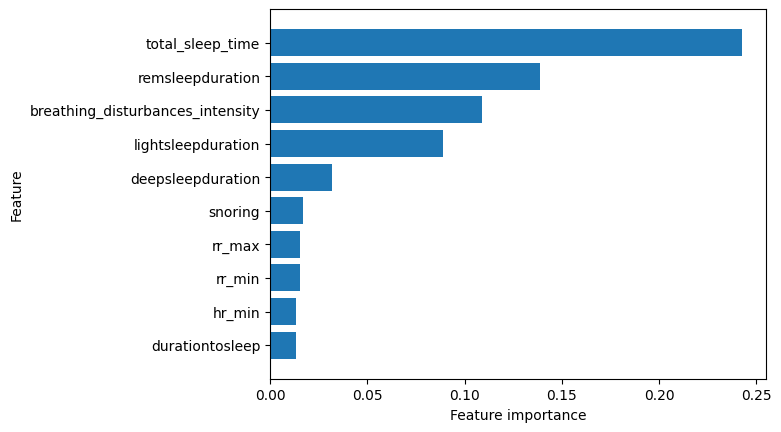

---------------------------------
정확도 :  0.9574468085106383


In [18]:
params=best_trial.params
print(params)
model = RandomForestClassifier(**params,random_state=100)
model.fit(X_train, y_train)

# 변수 중요도 계산
importances = model.feature_importances_
# 변수 중요도 내림차순 정렬
indices = np.argsort(importances)[::-1]

# 변수 중요도 및 변수 이름 출력
print("-------------변수중요도-------------")
for f in range(X_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))
n_features = 10 #X_train.shape[1]
print()
print("-------------변수중요도 시각화-------------")
plt.barh(np.arange(n_features),sorted(model.feature_importances_[indices[:10]]),align='center')
plt.yticks(np.arange(n_features)[::-1],X.columns[indices][:10])
plt.xlabel("Feature importance")
plt.ylabel('Feature')
plt.ylim(-1,n_features)
plt.show()
predictions=model.predict(X_test)
print("---------------------------------")
print('정확도 : ', accuracy_score(y_test,predictions)) ## 테스트 성능 평가 점수(Accuracy)

## origin/total
- RandomForest : 교차검증 정확도 82.7/ 테스트 정확도 70
- XGBoost : 교차검증 정확도 84.3/ 테스트 정확도 74.4

### 데이터 로드 및 전처리

In [8]:
data=pd.read_csv('2020_2th_paper_data_plus_activity_v2.csv')
data.drop(['Unnamed: 0','height_double','bmi','height','weight'],axis=1,inplace=True)
data=data.drop(['lastUpdate_month_8', 'lastUpdate_month_9', 'lastUpdate_month_10', 
'lastUpdate_weekend_0', 'lastUpdate_weekend_1', 'lastUpdate_weekend_2',
'lastUpdate_weekend_3', 'lastUpdate_weekend_4', 'lastUpdate_weekend_5', 'lastUpdate_weekend_6',
'lastUpdate_day_1', 'lastUpdate_day_2', 'lastUpdate_day_3', 'lastUpdate_day_4', 'lastUpdate_day_5',
'lastUpdate_day_6', 'lastUpdate_day_7', 'lastUpdate_day_8', 'lastUpdate_day_9', 'lastUpdate_day_10',
'lastUpdate_day_11', 'lastUpdate_day_12', 'lastUpdate_day_13', 'lastUpdate_day_14', 'lastUpdate_day_15',
'lastUpdate_day_16', 'lastUpdate_day_17', 'lastUpdate_day_18', 'lastUpdate_day_19', 'lastUpdate_day_20',
'lastUpdate_day_21', 'lastUpdate_day_22', 'lastUpdate_day_23', 'lastUpdate_day_24', 'lastUpdate_day_25',
'lastUpdate_day_26', 'lastUpdate_day_27', 'lastUpdate_day_28', 'lastUpdate_day_29', 'lastUpdate_day_30',
'lastUpdate_day_31'],axis=1)

# 총 수면시간 영향 제거
for x in ['wakeupduration','lightsleepduration', 'deepsleepduration', 'wakeupcount','durationtosleep', 'remsleepduration',
       'breathing_disturbances_intensity', 'snoring', 'snoringepisodecount','sleep_score']:
    data[x]=data[x]/data['total_sleep_time']
    
# 최종 예측변수 생성
data['sleep_classes'] = data['sleep_score'].apply(lambda x: 1 if x>=0.002595014321518081 else 0)
data.head()

,userId,date,sleep,amCondition,amEmotion,pmEmotion,pmStress,pmFatigue,cAmount(ml),aAmount(ml),...,761,762,763,764,791,792,793,91,92,sleep_classes
0,user01,2020-08-30,3.0,3.0,3.0,4.0,2.0,4.0,-1.0,-1.0,...,0,0,0,0,0,0,1,0,0,1
1,user01,2020-08-31,2.0,2.0,3.0,4.0,3.0,2.0,250.0,-1.0,...,0,0,0,0,0,0,1,0,0,1
2,user01,2020-09-07,4.0,3.0,4.0,4.0,4.0,2.0,500.0,-1.0,...,0,0,0,0,0,0,1,0,0,1
3,user01,2020-09-08,2.0,3.0,3.0,5.0,4.0,2.0,1500.0,1500.0,...,0,1,0,1,0,0,1,0,0,1
4,user01,2020-09-09,1.0,2.0,4.0,4.0,4.0,4.0,500.0,500.0,...,0,1,0,1,0,0,1,0,0,0


In [4]:
# 입력변수 설정
col=data.columns[2:-1]
X=data[col]

# 분류 대상 컬럼 제거
X=X.drop(['sleep_score','total_sleep_time'],axis=1)

# 출력변수 설정
y=data['sleep_classes']

# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=43)

## 연속형 변수 스케일링
col2=['durationtowakeup','hr_average', 'hr_min', 'hr_max', 'rr_average', 'rr_min', 'rr_max','cAmount(ml)','aAmount(ml)']
scaler=MinMaxScaler()
X_train[col2]=scaler.fit_transform(X_train[col2])
X_test[col2]=scaler.transform(X_test[col2])

### Randomforest

#### 교차검증 및 최적의 파라미터 추출

In [22]:
def objective(trial):
    params = {
            'n_estimators' :  trial.suggest_int('n_estimators', 1, 1000),
            'max_depth' : trial.suggest_int('max_depth', 1, 100),
            'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 1,100),
            'min_samples_split' : trial.suggest_int( 'min_samples_split', 1,100),
    }
    clf =  RandomForestClassifier(**params, random_state=100)

    skf = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=47)
    results = []
    CV_score_array=[]
    for train_idx, test_idx in skf.split(X_train,y_train):
        X_train_data,y_train_data = X_train.iloc[train_idx,:],y_train.iloc[train_idx]
        X_valid,y_valid = X_train.iloc[test_idx, :],y_train.iloc[test_idx]
        
        clf.fit(X_train_data, y_train_data)
        pred =clf.predict(X_valid)
        pred_proba = clf.predict_proba(X_valid)    
        accuracy = accuracy_score(y_valid, pred)    
        precision = precision_score(y_valid, pred, zero_division=0)
        recall = recall_score(y_valid, pred, zero_division=0)
        F1_score = f1_score(y_valid, pred, zero_division=0)
        auc = roc_auc_score(y_valid, pred_proba[:,1])
        results.append([accuracy, precision, recall, F1_score, auc])
        CV_score_array.append(accuracy)
        avg = np.mean(CV_score_array)
    return avg

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1000)

best_trial = study.best_trial
print("Best trial:")
print(best_trial.params)

[I 2023-10-11 00:04:42,288] A new study created in memory with name: no-name-578ca642-ca8d-4605-893d-c7c165a15183
[I 2023-10-11 00:04:45,867] Trial 0 finished with value: 0.7294117647058824 and parameters: {'n_estimators': 621, 'max_depth': 49, 'min_samples_leaf': 62, 'min_samples_split': 63}. Best is trial 0 with value: 0.7294117647058824.
[I 2023-10-11 00:04:48,176] Trial 1 finished with value: 0.7564705882352941 and parameters: {'n_estimators': 369, 'max_depth': 75, 'min_samples_leaf': 19, 'min_samples_split': 99}. Best is trial 1 with value: 0.7564705882352941.
[I 2023-10-11 00:04:53,820] Trial 2 finished with value: 0.7482352941176471 and parameters: {'n_estimators': 926, 'max_depth': 45, 'min_samples_leaf': 29, 'min_samples_split': 7}. Best is trial 1 with value: 0.7564705882352941.
[I 2023-10-11 00:04:57,005] Trial 3 finished with value: 0.7435294117647059 and parameters: {'n_estimators': 527, 'max_depth': 73, 'min_samples_leaf': 39, 'min_samples_split': 21}. Best is trial 1 wit

Best trial:
{'n_estimators': 92, 'max_depth': 85, 'min_samples_leaf': 1, 'min_samples_split': 13}


#### 테스트 정확도 및 변수 중요도 추출

{'n_estimators': 92, 'max_depth': 85, 'min_samples_leaf': 1, 'min_samples_split': 13}
-------------변수중요도-------------
1. breathing_disturbances_intensity (0.127390)
2. wakeupcount (0.066560)
3. remsleepduration (0.064208)
4. wakeupduration (0.059823)
5. durationtosleep (0.058389)
6. deepsleepduration (0.044135)
7. lightsleepduration (0.035676)
8. snoring (0.022598)
9. rr_max (0.019508)
10. hr_min (0.019479)
11. 792 (0.018411)
12. hr_max (0.015660)
13. snoringepisodecount (0.014535)
14. hr_average (0.013775)
15. cAmount(ml) (0.011875)
16. rr_min (0.011649)
17. rr_average (0.011316)
18. dream_4.0 (0.010705)
19. pmStress (0.009683)
20. sleep (0.009568)
21. 213 (0.008178)
22. amEmotion (0.008158)
23. aAmount(ml) (0.007850)
24. amCondition (0.007288)
25. 111 (0.007237)
26. dream_2.0 (0.007174)
27. sleep.1 (0.006584)
28. pmEmotion (0.006337)
29. 723 (0.006080)
30. 87 (0.006078)
31. durationtowakeup (0.005681)
32. bmi_label (0.005621)
33. 724 (0.005153)
34. pmFatigue (0.005075)
35. 791 (0.004

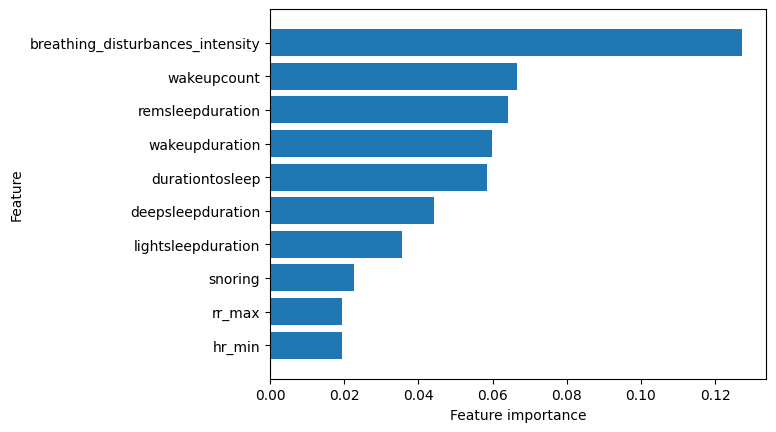

---------------------------------
정확도 :  0.7021276595744681


In [23]:
params=best_trial.params
print(params)
model = RandomForestClassifier(**params,random_state=100)
model.fit(X_train, y_train)

# 변수 중요도를 계산합니다.
importances = model.feature_importances_
# 변수 중요도를 내림차순으로 정렬합니다.
indices = np.argsort(importances)[::-1]

# 변수 중요도 및 변수 이름을 출력합니다.
print("-------------변수중요도-------------")
for f in range(X_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))
n_features = 10 #X_train.shape[1]
print()
print("-------------변수중요도 시각화-------------")
plt.barh(np.arange(n_features),sorted(model.feature_importances_[indices[:10]]),align='center')
plt.yticks(np.arange(n_features)[::-1],X.columns[indices][:10])
plt.xlabel("Feature importance")
plt.ylabel('Feature')
plt.ylim(-1,n_features)
plt.show()
predictions=model.predict(X_test)
print("---------------------------------")
print('정확도 : ', accuracy_score(y_test,predictions)) ## 테스트 성능 평가 점수(Accuracy)

### XGBoost

#### 교차검증 및 최적의 파라미터 추출

In [5]:
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 100),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0, step=0.05),
        'n_estimators': trial.suggest_int('n_estimators', 1,1000),
        'eta': trial.suggest_float('eta', 0.01, 1, step=0.01),
        'reg_alpha': trial.suggest_int('reg_alpha', 0, 100),
        'reg_lambda': trial.suggest_int('reg_lambda', 0, 100),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 100),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
    }
    
    clf =  XGBClassifier(**params, random_state=100)
    skf = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=47)
    results = []
    CV_score_array=[]
    for train_idx, test_idx in skf.split(X_train,y_train):
        X_train_data,y_train_data = X_train.iloc[train_idx,:],y_train.iloc[train_idx]
        X_valid,y_valid = X_train.iloc[test_idx, :],y_train.iloc[test_idx]
        clf.fit(X_train_data, y_train_data)
        pred =clf.predict(X_valid)
        pred_proba = clf.predict_proba(X_valid) 
        accuracy = accuracy_score(y_valid, pred)    
        precision = precision_score(y_valid, pred, zero_division=0)
        recall = recall_score(y_valid, pred, zero_division=0)
        F1_score = f1_score(y_valid, pred, zero_division=0)
        auc = roc_auc_score(y_valid, pred_proba[:,1])
        results.append([accuracy, precision, recall, F1_score, auc])
        CV_score_array.append(accuracy)
        avg = np.mean(CV_score_array)
    return avg

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1000)

best_trial = study.best_trial
print("Best trial:")
print(best_trial.params)


[I 2023-10-30 20:41:34,540] A new study created in memory with name: no-name-84de05aa-e91d-47e9-b1f9-a0e89b848bb5
[I 2023-10-30 20:41:37,024] Trial 0 finished with value: 0.5058823529411764 and parameters: {'max_depth': 91, 'subsample': 0.1, 'n_estimators': 414, 'eta': 0.63, 'reg_alpha': 85, 'reg_lambda': 2, 'min_child_weight': 75, 'colsample_bytree': 0.3729145833024802}. Best is trial 0 with value: 0.5058823529411764.
[I 2023-10-30 20:41:39,923] Trial 1 finished with value: 0.5035294117647059 and parameters: {'max_depth': 15, 'subsample': 0.25, 'n_estimators': 448, 'eta': 0.12, 'reg_alpha': 6, 'reg_lambda': 68, 'min_child_weight': 26, 'colsample_bytree': 0.8653931418510304}. Best is trial 0 with value: 0.5058823529411764.
[I 2023-10-30 20:41:44,468] Trial 2 finished with value: 0.5 and parameters: {'max_depth': 19, 'subsample': 0.30000000000000004, 'n_estimators': 721, 'eta': 0.12, 'reg_alpha': 13, 'reg_lambda': 76, 'min_child_weight': 23, 'colsample_bytree': 0.4414761461055162}. Best

Best trial:
{'max_depth': 67, 'subsample': 0.9500000000000001, 'n_estimators': 836, 'eta': 0.23, 'reg_alpha': 0, 'reg_lambda': 56, 'min_child_weight': 1, 'colsample_bytree': 0.8058908003529783}


#### 테스트 정확도 및 변수 중요도 추출

{'max_depth': 67, 'subsample': 0.9500000000000001, 'n_estimators': 836, 'eta': 0.23, 'reg_alpha': 0, 'reg_lambda': 56, 'min_child_weight': 1, 'colsample_bytree': 0.8058908003529783}
-------------변수중요도-------------
1. startDt_day_1 (0.057020)
2. endDt_month_8 (0.052937)
3. startDt_day_15 (0.029302)
4. recreation_media (0.028413)
5. endDt_day_15 (0.022872)
6. breathing_disturbances_intensity (0.022821)
7. endDt_day_3 (0.022370)
8. 57 (0.021597)
9. endDt_day_6 (0.020983)
10. sleep.1 (0.020477)
11. endDt_day_13 (0.020078)
12. sleepProblem_9.0 (0.019781)
13. 53 (0.019450)
14. age_0 (0.017416)
15. remsleepduration (0.016551)
16. startDt_month_10 (0.016225)
17. endDt_day_18 (0.016065)
18. startDt_day_5 (0.015740)
19. startDt_day_6 (0.015666)
20. personal_care (0.013773)
21. 111 (0.013483)
22. 792 (0.012725)
23. startDt_day_17 (0.012003)
24. dream_1.0 (0.011986)
25. 754 (0.011231)
26. 44 (0.011227)
27. 211 (0.010742)
28. startDt_day_12 (0.010296)
29. startDt_day_9 (0.009055)
30. startDt_month_

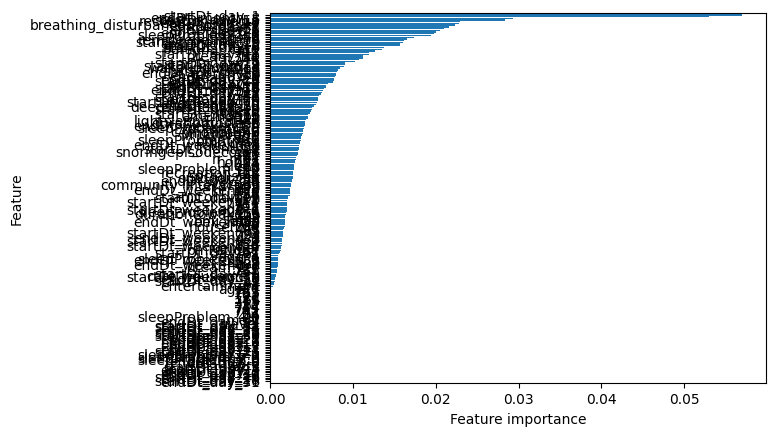

---------------------------------
정확도 :  0.7446808510638298


In [6]:
params=best_trial.params
print(params)
model = XGBClassifier(**params,random_state=100)
model.fit(X_train, y_train)

# 변수 중요도를 계산합니다.
importances = model.feature_importances_
# 변수 중요도를 내림차순으로 정렬합니다.
indices = np.argsort(importances)[::-1]

# 변수 중요도 및 변수 이름을 출력합니다.
print("-------------변수중요도-------------")
for f in range(X_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))
n_features = X_train.shape[1]
print()
print("-------------변수중요도 시각화-------------")
plt.barh(np.arange(n_features),sorted(model.feature_importances_),align='center')
plt.yticks(np.arange(n_features)[::-1],X.columns[indices])
plt.xlabel("Feature importance")
plt.ylabel('Feature')
plt.ylim(-1,n_features)
plt.show()
predictions=model.predict(X_test)
print("---------------------------------")
print('정확도 : ', accuracy_score(y_test,predictions)) ## 테스트 성능 평가 점수(Accuracy)

# deepsleepduration

## origin
- RandomForest : 교차검증 정확도 79.6/ 테스트 정확도 87.2
- XGBoost : 교차검증 정확도 84.3/ 테스트 정확도 74.4

### 데이터 로드 및 전처리

In [10]:
data=pd.read_csv('2020_2th_paper_data_plus_activity_v2.csv')
data.drop(['Unnamed: 0','height_double','bmi','height','weight'],axis=1,inplace=True)
data=data.drop(['lastUpdate_month_8', 'lastUpdate_month_9', 'lastUpdate_month_10', 
'lastUpdate_weekend_0', 'lastUpdate_weekend_1', 'lastUpdate_weekend_2',
'lastUpdate_weekend_3', 'lastUpdate_weekend_4', 'lastUpdate_weekend_5', 'lastUpdate_weekend_6',
'lastUpdate_day_1', 'lastUpdate_day_2', 'lastUpdate_day_3', 'lastUpdate_day_4', 'lastUpdate_day_5',
'lastUpdate_day_6', 'lastUpdate_day_7', 'lastUpdate_day_8', 'lastUpdate_day_9', 'lastUpdate_day_10',
'lastUpdate_day_11', 'lastUpdate_day_12', 'lastUpdate_day_13', 'lastUpdate_day_14', 'lastUpdate_day_15',
'lastUpdate_day_16', 'lastUpdate_day_17', 'lastUpdate_day_18', 'lastUpdate_day_19', 'lastUpdate_day_20',
'lastUpdate_day_21', 'lastUpdate_day_22', 'lastUpdate_day_23', 'lastUpdate_day_24', 'lastUpdate_day_25',
'lastUpdate_day_26', 'lastUpdate_day_27', 'lastUpdate_day_28', 'lastUpdate_day_29', 'lastUpdate_day_30',
'lastUpdate_day_31'],axis=1)

# 최종 예측변수 생성
data['sleep_classes'] = data['deepsleepduration'].apply(lambda x: 1 if x>5370.0 else 0)
data.head()

,userId,date,sleep,amCondition,amEmotion,pmEmotion,pmStress,pmFatigue,cAmount(ml),aAmount(ml),...,761,762,763,764,791,792,793,91,92,sleep_classes
0,user01,2020-08-30,3.0,3.0,3.0,4.0,2.0,4.0,-1.0,-1.0,...,0,0,0,0,0,0,1,0,0,1
1,user01,2020-08-31,2.0,2.0,3.0,4.0,3.0,2.0,250.0,-1.0,...,0,0,0,0,0,0,1,0,0,1
2,user01,2020-09-07,4.0,3.0,4.0,4.0,4.0,2.0,500.0,-1.0,...,0,0,0,0,0,0,1,0,0,1
3,user01,2020-09-08,2.0,3.0,3.0,5.0,4.0,2.0,1500.0,1500.0,...,0,1,0,1,0,0,1,0,0,1
4,user01,2020-09-09,1.0,2.0,4.0,4.0,4.0,4.0,500.0,500.0,...,0,1,0,1,0,0,1,0,0,1


In [100]:
# 입력변수 설정
col=data.columns[2:-1]
X=data[col]

# 분류 대상 컬럼 제거
X=X.drop(['sleep_score','deepsleepduration'],axis=1)

# 출력변수 설정
y=data['sleep_classes']

# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=43)

## 연속형 변수 스케일링
col2=['total_sleep_time','wakeupduration','lightsleepduration', 'wakeupcount','durationtosleep', 'remsleepduration','durationtowakeup','hr_average', 'hr_min',
       'hr_max', 'rr_average', 'rr_min', 'rr_max','breathing_disturbances_intensity', 'snoring', 'snoringepisodecount','cAmount(ml)','aAmount(ml)']
scaler=MinMaxScaler()
X_train[col2]=scaler.fit_transform(X_train[col2])
X_test[col2]=scaler.transform(X_test[col2])

### RandomForest 

#### 교차검증 및 최적의 파라미터 추출

In [33]:
def objective(trial):
    params = {
            'n_estimators' :  trial.suggest_int('n_estimators', 1, 1000),
            'max_depth' : trial.suggest_int('max_depth', 1, 100),
            'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 1,100),
            'min_samples_split' : trial.suggest_int( 'min_samples_split', 1,100),
    }
    clf =  RandomForestClassifier(**params, random_state=100)

    skf = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=47)
    results = []
    CV_score_array=[]
    for train_idx, test_idx in skf.split(X_train,y_train):
        X_train_data,y_train_data = X_train.iloc[train_idx,:],y_train.iloc[train_idx]
        X_valid,y_valid = X_train.iloc[test_idx, :],y_train.iloc[test_idx]
        
        clf.fit(X_train_data, y_train_data)
        pred =clf.predict(X_valid)
        pred_proba = clf.predict_proba(X_valid)    
        accuracy = accuracy_score(y_valid, pred)    
        precision = precision_score(y_valid, pred, zero_division=0)
        recall = recall_score(y_valid, pred, zero_division=0)
        F1_score = f1_score(y_valid, pred, zero_division=0)
        auc = roc_auc_score(y_valid, pred_proba[:,1])
        results.append([accuracy, precision, recall, F1_score, auc])
        CV_score_array.append(accuracy)
        avg = np.mean(CV_score_array)
    return avg

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1000)

best_trial = study.best_trial
print("Best trial:")
print(best_trial.params)

[I 2023-10-11 02:17:06,988] A new study created in memory with name: no-name-c0d7a73f-a3f5-44d3-8179-afdd0e925a9b
[I 2023-10-11 02:17:07,576] Trial 0 finished with value: 0.7576470588235293 and parameters: {'n_estimators': 86, 'max_depth': 28, 'min_samples_leaf': 33, 'min_samples_split': 68}. Best is trial 0 with value: 0.7576470588235293.
[I 2023-10-11 02:17:11,246] Trial 1 finished with value: 0.6058823529411764 and parameters: {'n_estimators': 639, 'max_depth': 48, 'min_samples_leaf': 98, 'min_samples_split': 55}. Best is trial 0 with value: 0.7576470588235293.
[I 2023-10-11 02:17:16,094] Trial 2 finished with value: 0.7364705882352942 and parameters: {'n_estimators': 822, 'max_depth': 34, 'min_samples_leaf': 52, 'min_samples_split': 63}. Best is trial 0 with value: 0.7576470588235293.
[I 2023-10-11 02:17:20,520] Trial 3 finished with value: 0.7129411764705882 and parameters: {'n_estimators': 768, 'max_depth': 78, 'min_samples_leaf': 66, 'min_samples_split': 42}. Best is trial 0 wit

Best trial:
{'n_estimators': 737, 'max_depth': 82, 'min_samples_leaf': 1, 'min_samples_split': 27}


#### 테스트 정확도 및 변수 중요도 추출

{'n_estimators': 737, 'max_depth': 82, 'min_samples_leaf': 1, 'min_samples_split': 27}
-------------변수중요도-------------
1. total_sleep_time (0.067513)
2. remsleepduration (0.062973)
3. hr_average (0.040888)
4. rr_average (0.039843)
5. breathing_disturbances_intensity (0.037277)
6. lightsleepduration (0.036470)
7. hr_max (0.033094)
8. snoringepisodecount (0.028212)
9. snoring (0.025944)
10. hr_min (0.025014)
11. 212 (0.024204)
12. 756 (0.023616)
13. socialising (0.019846)
14. 762 (0.018541)
15. rr_max (0.017960)
16. cAmount(ml) (0.017707)
17. rr_min (0.017168)
18. wakeupduration (0.014545)
19. durationtosleep (0.013743)
20. 46 (0.013562)
21. 45 (0.011632)
22. 711 (0.011183)
23. gender (0.010651)
24. wakeupcount (0.009307)
25. 713 (0.009218)
26. pmFatigue (0.009076)
27. age_3 (0.008934)
28. 61 (0.008564)
29. 53 (0.008499)
30. pmEmotion (0.008465)
31. age_1 (0.008397)
32. sleep (0.008076)
33. community_interaction (0.007747)
34. care_housemem (0.007058)
35. aAmount(ml) (0.006651)
36. durat

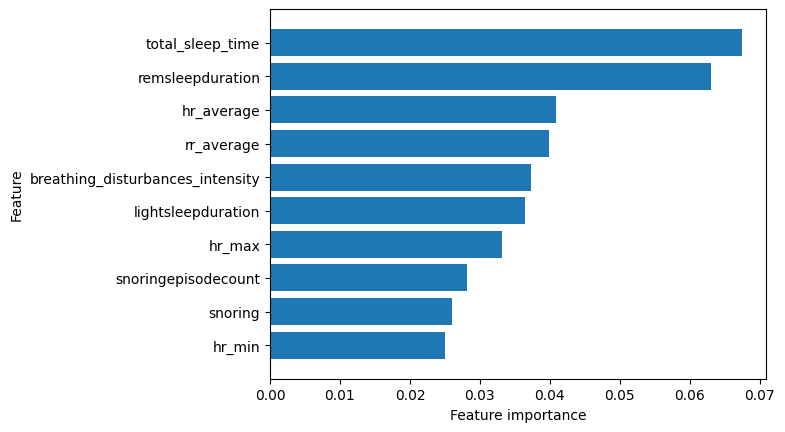

---------------------------------
정확도 :  0.8723404255319149


In [34]:
params=best_trial.params
print(params)
model = RandomForestClassifier(**params,random_state=100)
model.fit(X_train, y_train)

# 변수 중요도를 계산합니다.
importances = model.feature_importances_
# 변수 중요도를 내림차순으로 정렬합니다.
indices = np.argsort(importances)[::-1]

# 변수 중요도 및 변수 이름을 출력합니다.
print("-------------변수중요도-------------")
for f in range(X_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))
n_features = 10 #X_train.shape[1]
print()
print("-------------변수중요도 시각화-------------")
plt.barh(np.arange(n_features),sorted(model.feature_importances_[indices[:10]]),align='center')
plt.yticks(np.arange(n_features)[::-1],X.columns[indices][:10])
plt.xlabel("Feature importance")
plt.ylabel('Feature')
plt.ylim(-1,n_features)
plt.show()
predictions=model.predict(X_test)
print("---------------------------------")
print('정확도 : ', accuracy_score(y_test,predictions)) ## 테스트 성능 평가 점수(Accuracy)

### XGBoost

#### 교차검증 및 최적의 파라미터 추출

In [101]:
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 100),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0, step=0.05),
        'n_estimators': trial.suggest_int('n_estimators', 1,1000),
        'eta': trial.suggest_float('eta', 0.01, 1, step=0.01),
        'reg_alpha': trial.suggest_int('reg_alpha', 0, 100),
        'reg_lambda': trial.suggest_int('reg_lambda', 0, 100),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 100),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
    }
    
    clf =  XGBClassifier(**params, random_state=100)
    skf = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=47)
    results = []
    CV_score_array=[]
    for train_idx, test_idx in skf.split(X_train,y_train):
        X_train_data,y_train_data = X_train.iloc[train_idx,:],y_train.iloc[train_idx]
        X_valid,y_valid = X_train.iloc[test_idx, :],y_train.iloc[test_idx]
        clf.fit(X_train_data, y_train_data)
        pred =clf.predict(X_valid)
        pred_proba = clf.predict_proba(X_valid) 
        accuracy = accuracy_score(y_valid, pred)    
        precision = precision_score(y_valid, pred, zero_division=0)
        recall = recall_score(y_valid, pred, zero_division=0)
        F1_score = f1_score(y_valid, pred, zero_division=0)
        auc = roc_auc_score(y_valid, pred_proba[:,1])
        results.append([accuracy, precision, recall, F1_score, auc])
        CV_score_array.append(accuracy)
        avg = np.mean(CV_score_array)
    return avg

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1000)

best_trial = study.best_trial
print("Best trial:")
print(best_trial.params)


[I 2023-10-13 17:07:44,314] A new study created in memory with name: no-name-2537de39-31b6-4fdc-ad1d-e09fb3889003
[I 2023-10-13 17:07:47,232] Trial 0 finished with value: 0.5294117647058824 and parameters: {'max_depth': 97, 'subsample': 0.1, 'n_estimators': 482, 'eta': 0.49, 'reg_alpha': 69, 'reg_lambda': 42, 'min_child_weight': 54, 'colsample_bytree': 0.7111284713594967}. Best is trial 0 with value: 0.5294117647058824.
[I 2023-10-13 17:07:53,697] Trial 1 finished with value: 0.5294117647058824 and parameters: {'max_depth': 9, 'subsample': 0.6, 'n_estimators': 965, 'eta': 0.09999999999999999, 'reg_alpha': 58, 'reg_lambda': 36, 'min_child_weight': 85, 'colsample_bytree': 0.8589979522424672}. Best is trial 0 with value: 0.5294117647058824.
[I 2023-10-13 17:07:54,711] Trial 2 finished with value: 0.5294117647058824 and parameters: {'max_depth': 49, 'subsample': 0.25, 'n_estimators': 152, 'eta': 0.72, 'reg_alpha': 30, 'reg_lambda': 63, 'min_child_weight': 92, 'colsample_bytree': 0.58503461

Best trial:
{'max_depth': 75, 'subsample': 1.0, 'n_estimators': 865, 'eta': 0.28, 'reg_alpha': 0, 'reg_lambda': 21, 'min_child_weight': 3, 'colsample_bytree': 0.7188454643368034}


#### 테스트 정확도 및 변수 중요도 추출

{'max_depth': 75, 'subsample': 1.0, 'n_estimators': 865, 'eta': 0.28, 'reg_alpha': 0, 'reg_lambda': 21, 'min_child_weight': 3, 'colsample_bytree': 0.7188454643368034}
-------------변수중요도-------------
1. 762 (0.199073)
2. socialising (0.056469)
3. 56 (0.042474)
4. 791 (0.040272)
5. recreation_media (0.036329)
6. 111 (0.026802)
7. 51 (0.024887)
8. 86 (0.022772)
9. 45 (0.021710)
10. age_0 (0.021559)
11. rr_average (0.020206)
12. 212 (0.019043)
13. 55 (0.019041)
14. aAmount(ml) (0.016342)
15. 46 (0.015414)
16. 134 (0.015005)
17. community_interaction (0.014697)
18. endDt_weekend_4 (0.010834)
19. 721 (0.010520)
20. 711 (0.009968)
21. durationtowakeup (0.009853)
22. cAmount(ml) (0.009852)
23. 63 (0.009740)
24. startDt_weekend_1 (0.009678)
25. study (0.009335)
26. 756 (0.009208)
27. 42 (0.009181)
28. 722 (0.009152)
29. hr_average (0.008849)
30. age_2 (0.008583)
31. lightsleepduration (0.008186)
32. snoringepisodecount (0.008166)
33. startDt_weekend_4 (0.008140)
34. total_sleep_time (0.008126)


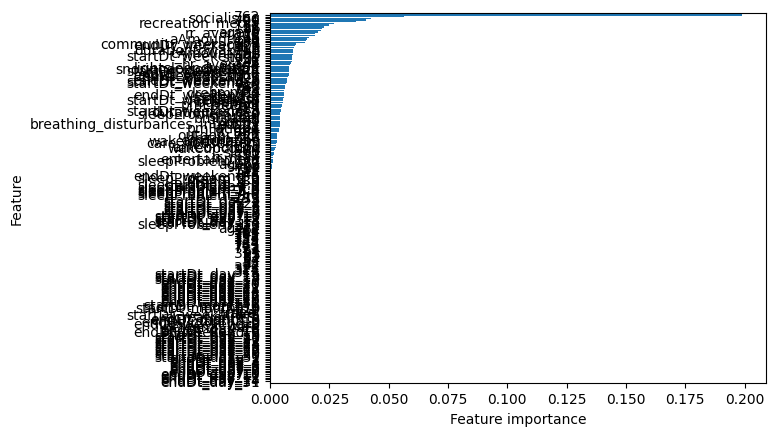

---------------------------------
정확도 :  0.9148936170212766


In [102]:
params=best_trial.params
print(params)
model = XGBClassifier(**params,random_state=100)
model.fit(X_train, y_train)

# 변수 중요도를 계산합니다.
importances = model.feature_importances_
# 변수 중요도를 내림차순으로 정렬합니다.
indices = np.argsort(importances)[::-1]

# 변수 중요도 및 변수 이름을 출력합니다.
print("-------------변수중요도-------------")
for f in range(X_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))
n_features = X_train.shape[1]
print()
print("-------------변수중요도 시각화-------------")
plt.barh(np.arange(n_features),sorted(model.feature_importances_),align='center')
plt.yticks(np.arange(n_features)[::-1],X.columns[indices])
plt.xlabel("Feature importance")
plt.ylabel('Feature')
plt.ylim(-1,n_features)
plt.show()
predictions=model.predict(X_test)
print("---------------------------------")
print('정확도 : ', accuracy_score(y_test,predictions)) ## 테스트 성능 평가 점수(Accuracy)

## origin/total
- RandomForest : 교차검증 정확도 83.5/ 테스트 정확도 82.9
- XGBoost : 교차검증 정확도 94/ 테스트 정확도 93.6

### 데이터 로드 및 전처리

In [35]:
data=pd.read_csv('2020_2th_paper_data_plus_activity_v2.csv')
data.drop(['Unnamed: 0','height_double','bmi','height','weight'],axis=1, inplace=True)
data=data.drop(['lastUpdate_month_8', 'lastUpdate_month_9', 'lastUpdate_month_10', 
'lastUpdate_weekend_0', 'lastUpdate_weekend_1', 'lastUpdate_weekend_2',
'lastUpdate_weekend_3', 'lastUpdate_weekend_4', 'lastUpdate_weekend_5', 'lastUpdate_weekend_6',
'lastUpdate_day_1', 'lastUpdate_day_2', 'lastUpdate_day_3', 'lastUpdate_day_4', 'lastUpdate_day_5',
'lastUpdate_day_6', 'lastUpdate_day_7', 'lastUpdate_day_8', 'lastUpdate_day_9', 'lastUpdate_day_10',
'lastUpdate_day_11', 'lastUpdate_day_12', 'lastUpdate_day_13', 'lastUpdate_day_14', 'lastUpdate_day_15',
'lastUpdate_day_16', 'lastUpdate_day_17', 'lastUpdate_day_18', 'lastUpdate_day_19', 'lastUpdate_day_20',
'lastUpdate_day_21', 'lastUpdate_day_22', 'lastUpdate_day_23', 'lastUpdate_day_24', 'lastUpdate_day_25',
'lastUpdate_day_26', 'lastUpdate_day_27', 'lastUpdate_day_28', 'lastUpdate_day_29', 'lastUpdate_day_30',
'lastUpdate_day_31'],axis=1)

# 총 수면시간 영향 제거
for x in ['wakeupduration','lightsleepduration', 'deepsleepduration', 'wakeupcount','durationtosleep', 'remsleepduration',
       'breathing_disturbances_intensity', 'snoring', 'snoringepisodecount','sleep_score']:
    data[x]=data[x]/data['total_sleep_time']

# 최종 예측변수 생성
data['sleep_classes'] = data['deepsleepduration'].apply(lambda x: 1 if x>=0.2673794848818764 else 0)
data.head()

,userId,date,sleep,amCondition,amEmotion,pmEmotion,pmStress,pmFatigue,cAmount(ml),aAmount(ml),...,761,762,763,764,791,792,793,91,92,sleep_classes
0,user01,2020-08-30,3.0,3.0,3.0,4.0,2.0,4.0,-1.0,-1.0,...,0,0,0,0,0,0,1,0,0,0
1,user01,2020-08-31,2.0,2.0,3.0,4.0,3.0,2.0,250.0,-1.0,...,0,0,0,0,0,0,1,0,0,1
2,user01,2020-09-07,4.0,3.0,4.0,4.0,4.0,2.0,500.0,-1.0,...,0,0,0,0,0,0,1,0,0,0
3,user01,2020-09-08,2.0,3.0,3.0,5.0,4.0,2.0,1500.0,1500.0,...,0,1,0,1,0,0,1,0,0,1
4,user01,2020-09-09,1.0,2.0,4.0,4.0,4.0,4.0,500.0,500.0,...,0,1,0,1,0,0,1,0,0,1


In [37]:
# 입력변수 설정
col=data.columns[2:-1]
X=data[col]

# 분류 대상 컬럼 제거
X=X.drop(['sleep_score','total_sleep_time','deepsleepduration'],axis=1)

# 출력변수 설정
y=data['sleep_classes']

# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=43)

## 연속형 변수 스케일링
col2=['durationtowakeup','hr_average', 'hr_min', 'hr_max', 'rr_average', 'rr_min', 'rr_max','cAmount(ml)','aAmount(ml)']
scaler=MinMaxScaler()
X_train[col2]=scaler.fit_transform(X_train[col2])
X_test[col2]=scaler.transform(X_test[col2])

### randomforest

#### 교차검증 및 최적의 파라미터 추출

In [38]:
def objective(trial):
    params = {
            'n_estimators' :  trial.suggest_int('n_estimators', 1, 1000),
            'max_depth' : trial.suggest_int('max_depth', 1, 100),
            'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 1,100),
            'min_samples_split' : trial.suggest_int( 'min_samples_split', 1,100),
    }
    clf =  RandomForestClassifier(**params, random_state=100)

    skf = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=47)
    results = []
    CV_score_array=[]
    for train_idx, test_idx in skf.split(X_train,y_train):
        X_train_data,y_train_data = X_train.iloc[train_idx,:],y_train.iloc[train_idx]
        X_valid,y_valid = X_train.iloc[test_idx, :],y_train.iloc[test_idx]
        
        clf.fit(X_train_data, y_train_data)
        pred =clf.predict(X_valid)
        pred_proba = clf.predict_proba(X_valid)    
        accuracy = accuracy_score(y_valid, pred)    
        precision = precision_score(y_valid, pred, zero_division=0)
        recall = recall_score(y_valid, pred, zero_division=0)
        F1_score = f1_score(y_valid, pred, zero_division=0)
        auc = roc_auc_score(y_valid, pred_proba[:,1])
        results.append([accuracy, precision, recall, F1_score, auc])
        CV_score_array.append(accuracy)
        avg = np.mean(CV_score_array)
    return avg

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1000)

best_trial = study.best_trial
print("Best trial:")
print(best_trial.params)

[I 2023-10-11 03:42:35,129] A new study created in memory with name: no-name-78050422-9678-45ee-be77-517b6de2c6cc
[I 2023-10-11 03:42:40,945] Trial 0 finished with value: 0.7929411764705881 and parameters: {'n_estimators': 976, 'max_depth': 96, 'min_samples_leaf': 53, 'min_samples_split': 23}. Best is trial 0 with value: 0.7929411764705881.
[I 2023-10-11 03:42:41,369] Trial 1 finished with value: 0.6764705882352942 and parameters: {'n_estimators': 63, 'max_depth': 25, 'min_samples_leaf': 86, 'min_samples_split': 42}. Best is trial 0 with value: 0.7929411764705881.
[I 2023-10-11 03:42:43,712] Trial 2 finished with value: 0.8011764705882353 and parameters: {'n_estimators': 378, 'max_depth': 90, 'min_samples_leaf': 31, 'min_samples_split': 30}. Best is trial 2 with value: 0.8011764705882353.
[I 2023-10-11 03:42:47,487] Trial 3 finished with value: 0.7858823529411765 and parameters: {'n_estimators': 633, 'max_depth': 62, 'min_samples_leaf': 59, 'min_samples_split': 65}. Best is trial 2 wit

Best trial:
{'n_estimators': 839, 'max_depth': 83, 'min_samples_leaf': 6, 'min_samples_split': 7}


#### 테스트 정확도 및 변수 중요도 추출

{'n_estimators': 839, 'max_depth': 83, 'min_samples_leaf': 6, 'min_samples_split': 7}
-------------변수중요도-------------
1. lightsleepduration (0.199460)
2. breathing_disturbances_intensity (0.043842)
3. hr_average (0.043630)
4. hr_min (0.037919)
5. remsleepduration (0.033830)
6. snoringepisodecount (0.032653)
7. snoring (0.030481)
8. rr_average (0.029270)
9. socialising (0.027249)
10. rr_min (0.025943)
11. durationtosleep (0.022157)
12. wakeupduration (0.021684)
13. hr_max (0.021123)
14. 711 (0.020955)
15. outdoor_act (0.017281)
16. 212 (0.017080)
17. wakeupcount (0.014603)
18. age_1 (0.014285)
19. cAmount(ml) (0.014019)
20. rr_max (0.013500)
21. 756 (0.010523)
22. 46 (0.009338)
23. gender (0.008712)
24. 713 (0.008166)
25. pmEmotion (0.007897)
26. 41 (0.007691)
27. age_3 (0.007593)
28. pmFatigue (0.007375)
29. bmi_label (0.007276)
30. 721 (0.006597)
31. 53 (0.006501)
32. sleep (0.006413)
33. 762 (0.006325)
34. 57 (0.006084)
35. 751 (0.005735)
36. pmStress (0.005519)
37. amCondition (0.00

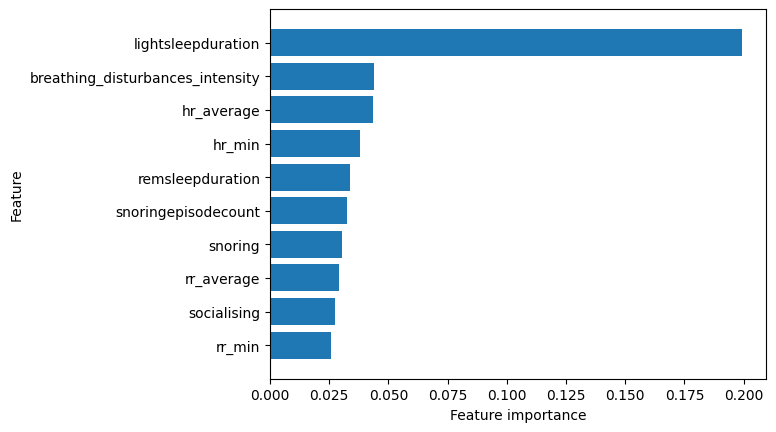

---------------------------------
정확도 :  0.8297872340425532


In [39]:
params=best_trial.params
print(params)
model = RandomForestClassifier(**params,random_state=100)
model.fit(X_train, y_train)

# 변수 중요도를 계산합니다.
importances = model.feature_importances_
# 변수 중요도를 내림차순으로 정렬합니다.
indices = np.argsort(importances)[::-1]

# 변수 중요도 및 변수 이름을 출력합니다.
print("-------------변수중요도-------------")
for f in range(X_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))
n_features = 10 #X_train.shape[1]
print()
print("-------------변수중요도 시각화-------------")
plt.barh(np.arange(n_features),sorted(model.feature_importances_[indices[:10]]),align='center')
plt.yticks(np.arange(n_features)[::-1],X.columns[indices][:10])
plt.xlabel("Feature importance")
plt.ylabel('Feature')
plt.ylim(-1,n_features)
plt.show()
predictions=model.predict(X_test)
print("---------------------------------")
print('정확도 : ', accuracy_score(y_test,predictions)) ## 테스트 성능 평가 점수(Accuracy)

### xgboost

#### 교차검증 및 최적의 파라미터 추출

In [40]:
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 100),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0, step=0.05),
        'n_estimators': trial.suggest_int('n_estimators', 1,1000),
        'eta': trial.suggest_float('eta', 0.01, 1, step=0.01),
        'reg_alpha': trial.suggest_int('reg_alpha', 0, 100),
        'reg_lambda': trial.suggest_int('reg_lambda', 0, 100),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 100),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
    }
    
    clf =  XGBClassifier(**params, random_state=100)
    skf = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=47)
    results = []
    CV_score_array=[]
    for train_idx, test_idx in skf.split(X_train,y_train):
        X_train_data,y_train_data = X_train.iloc[train_idx,:],y_train.iloc[train_idx]
        X_valid,y_valid = X_train.iloc[test_idx, :],y_train.iloc[test_idx]
        clf.fit(X_train_data, y_train_data)
        pred =clf.predict(X_valid)
        pred_proba = clf.predict_proba(X_valid) 
        accuracy = accuracy_score(y_valid, pred)    
        precision = precision_score(y_valid, pred, zero_division=0)
        recall = recall_score(y_valid, pred, zero_division=0)
        F1_score = f1_score(y_valid, pred, zero_division=0)
        auc = roc_auc_score(y_valid, pred_proba[:,1])
        results.append([accuracy, precision, recall, F1_score, auc])
        CV_score_array.append(accuracy)
        avg = np.mean(CV_score_array)
    return avg

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1000)

best_trial = study.best_trial
print("Best trial:")
print(best_trial.params)


[I 2023-10-11 09:53:41,285] A new study created in memory with name: no-name-3d8ea2d0-7213-4d03-819d-a70e65c5d1a8
[I 2023-10-11 09:53:44,726] Trial 0 finished with value: 0.5176470588235295 and parameters: {'max_depth': 10, 'subsample': 0.9500000000000001, 'n_estimators': 579, 'eta': 0.4, 'reg_alpha': 76, 'reg_lambda': 17, 'min_child_weight': 96, 'colsample_bytree': 0.2182780376815482}. Best is trial 0 with value: 0.5176470588235295.
[I 2023-10-11 09:53:50,767] Trial 1 finished with value: 0.5176470588235295 and parameters: {'max_depth': 62, 'subsample': 0.7000000000000001, 'n_estimators': 944, 'eta': 0.3, 'reg_alpha': 68, 'reg_lambda': 57, 'min_child_weight': 20, 'colsample_bytree': 0.887350313365298}. Best is trial 0 with value: 0.5176470588235295.
[I 2023-10-11 09:53:51,401] Trial 2 finished with value: 0.5176470588235295 and parameters: {'max_depth': 59, 'subsample': 0.4, 'n_estimators': 87, 'eta': 1.0, 'reg_alpha': 92, 'reg_lambda': 13, 'min_child_weight': 37, 'colsample_bytree': 

Best trial:
{'max_depth': 30, 'subsample': 1.0, 'n_estimators': 623, 'eta': 0.8400000000000001, 'reg_alpha': 0, 'reg_lambda': 76, 'min_child_weight': 3, 'colsample_bytree': 0.9252250310410635}


#### 테스트 정확도 및 변수 중요도 추출

{'max_depth': 30, 'subsample': 1.0, 'n_estimators': 623, 'eta': 0.8400000000000001, 'reg_alpha': 0, 'reg_lambda': 76, 'min_child_weight': 3, 'colsample_bytree': 0.9252250310410635}
-------------변수중요도-------------
1. snoring (0.127263)
2. 55 (0.124731)
3. 713 (0.104855)
4. 792 (0.094434)
5. 763 (0.077391)
6. lightsleepduration (0.077030)
7. hr_average (0.055179)
8. socialising (0.053995)
9. 791 (0.045292)
10. 724 (0.030678)
11. remsleepduration (0.025223)
12. endDt_weekend_4 (0.022832)
13. breathing_disturbances_intensity (0.014654)
14. 756 (0.011931)
15. age_1 (0.011026)
16. rr_average (0.010743)
17. snoringepisodecount (0.007674)
18. 81 (0.007615)
19. amEmotion (0.006692)
20. durationtosleep (0.006583)
21. 41 (0.006036)
22. 212 (0.005913)
23. hr_max (0.005780)
24. 87 (0.005328)
25. outdoor_act (0.005110)
26. pmFatigue (0.004870)
27. 91 (0.004840)
28. wakeupduration (0.004696)
29. cAmount(ml) (0.004469)
30. 46 (0.004248)
31. 92 (0.003585)
32. 751 (0.003281)
33. sleep (0.002798)
34. rr_

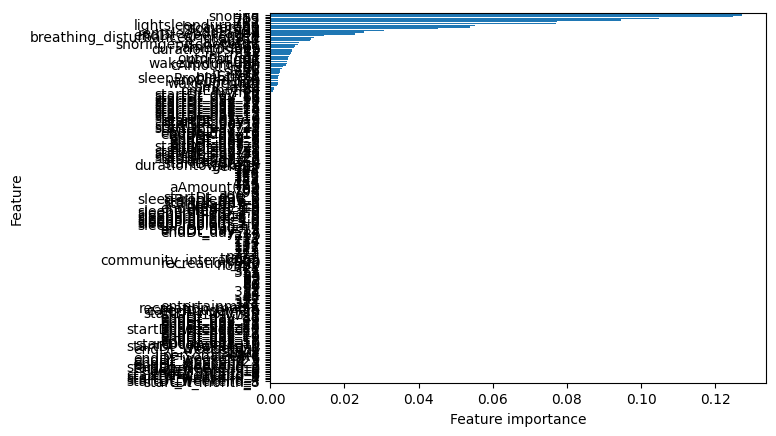

---------------------------------
정확도 :  0.9361702127659575


In [41]:
params=best_trial.params
print(params)
model = XGBClassifier(**params,random_state=100)
model.fit(X_train, y_train)

# 변수 중요도를 계산합니다.
importances = model.feature_importances_
# 변수 중요도를 내림차순으로 정렬합니다.
indices = np.argsort(importances)[::-1]

# 변수 중요도 및 변수 이름을 출력합니다.
print("-------------변수중요도-------------")
for f in range(X_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))
n_features = X_train.shape[1]
print()
print("-------------변수중요도 시각화-------------")
plt.barh(np.arange(n_features),sorted(model.feature_importances_),align='center')
plt.yticks(np.arange(n_features)[::-1],X.columns[indices])
plt.xlabel("Feature importance")
plt.ylabel('Feature')
plt.ylim(-1,n_features)
plt.show()
predictions=model.predict(X_test)
print("---------------------------------")
print('정확도 : ', accuracy_score(y_test,predictions)) ## 테스트 성능 평가 점수(Accuracy)

### 주요 지표 기반
- RandomForest : 교차검증 정확도 91.6 
- XGBoost : 교차검증 정확도 95.7

#### 데이터 로드 및 전처리

In [22]:
data=pd.read_csv('2020_2th_paper_data_plus_activity_v2.csv')
data.drop(['Unnamed: 0','height_double','bmi','height','weight'],axis=1, inplace=True)
data=data.drop(['lastUpdate_month_8', 'lastUpdate_month_9', 'lastUpdate_month_10', 
'lastUpdate_weekend_0', 'lastUpdate_weekend_1', 'lastUpdate_weekend_2',
'lastUpdate_weekend_3', 'lastUpdate_weekend_4', 'lastUpdate_weekend_5', 'lastUpdate_weekend_6',
'lastUpdate_day_1', 'lastUpdate_day_2', 'lastUpdate_day_3', 'lastUpdate_day_4', 'lastUpdate_day_5',
'lastUpdate_day_6', 'lastUpdate_day_7', 'lastUpdate_day_8', 'lastUpdate_day_9', 'lastUpdate_day_10',
'lastUpdate_day_11', 'lastUpdate_day_12', 'lastUpdate_day_13', 'lastUpdate_day_14', 'lastUpdate_day_15',
'lastUpdate_day_16', 'lastUpdate_day_17', 'lastUpdate_day_18', 'lastUpdate_day_19', 'lastUpdate_day_20',
'lastUpdate_day_21', 'lastUpdate_day_22', 'lastUpdate_day_23', 'lastUpdate_day_24', 'lastUpdate_day_25',
'lastUpdate_day_26', 'lastUpdate_day_27', 'lastUpdate_day_28', 'lastUpdate_day_29', 'lastUpdate_day_30',
'lastUpdate_day_31'],axis=1)

# 총 수면시간 영향 제거
for x in ['wakeupduration','lightsleepduration', 'deepsleepduration', 'wakeupcount','durationtosleep', 'remsleepduration',
       'breathing_disturbances_intensity', 'snoring', 'snoringepisodecount','sleep_score']:
    data[x]=data[x]/data['total_sleep_time']

# 최종 예측변수 생성
data['sleep_classes'] = data['deepsleepduration'].apply(lambda x: 1 if x>=0.2673794848818764 else 0)
data.head()

,userId,date,sleep,amCondition,amEmotion,pmEmotion,pmStress,pmFatigue,cAmount(ml),aAmount(ml),...,761,762,763,764,791,792,793,91,92,sleep_classes
0,user01,2020-08-30,3.0,3.0,3.0,4.0,2.0,4.0,-1.0,-1.0,...,0,0,0,0,0,0,1,0,0,0
1,user01,2020-08-31,2.0,2.0,3.0,4.0,3.0,2.0,250.0,-1.0,...,0,0,0,0,0,0,1,0,0,1
2,user01,2020-09-07,4.0,3.0,4.0,4.0,4.0,2.0,500.0,-1.0,...,0,0,0,0,0,0,1,0,0,0
3,user01,2020-09-08,2.0,3.0,3.0,5.0,4.0,2.0,1500.0,1500.0,...,0,1,0,1,0,0,1,0,0,1
4,user01,2020-09-09,1.0,2.0,4.0,4.0,4.0,4.0,500.0,500.0,...,0,1,0,1,0,0,1,0,0,1


In [26]:
# 1. lightsleepduration (0.199460)
# 2. breathing_disturbances_intensity (0.043842)
# 3. hr_average (0.043630)
# 4. hr_min (0.037919)
# 5. remsleepduration (0.033830)
# 6. snoringepisodecount (0.032653)
# 7. snoring (0.030481)
# 8. rr_average (0.029270)
# 9. socialising (0.027249)
X = data[['breathing_disturbances_intensity','hr_average','hr_min','remsleepduration','snoringepisodecount','lightsleepduration','snoring','rr_average','socialising']]
y = data['sleep_classes']
        
# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=43)

# 스케일링
col2= ['hr_average','hr_min','rr_average']
scaler=MinMaxScaler()
X_train[col2]=scaler.fit_transform(X_train[col2])
X_test[col2]=scaler.transform(X_test[col2])

#### 교차검증 및 최적의 파라미터 추출

##### Random Forest

In [27]:
def objective(trial):
    params = {
            'n_estimators' :  trial.suggest_int('n_estimators', 1, 1000),
            'max_depth' : trial.suggest_int('max_depth', 1, 100),
            'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 1,100),
            'min_samples_split' : trial.suggest_int( 'min_samples_split', 1,100),
    }
    clf =  RandomForestClassifier(**params, random_state=100)

    skf = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=47)
    results = []
    CV_score_array=[]
    for train_idx, test_idx in skf.split(X_train,y_train):
        X_train_data,y_train_data = X_train.iloc[train_idx,:],y_train.iloc[train_idx]
        X_valid,y_valid = X_train.iloc[test_idx, :],y_train.iloc[test_idx]
        
        clf.fit(X_train_data, y_train_data) 
        pred =clf.predict(X_valid)
        pred_proba = clf.predict_proba(X_valid)    
        accuracy = accuracy_score(y_valid, pred)    
        precision = precision_score(y_valid, pred, zero_division=0)
        recall = recall_score(y_valid, pred, zero_division=0)
        F1_score = f1_score(y_valid, pred, zero_division=0)
        auc = roc_auc_score(y_valid, pred_proba[:,1])
        results.append([accuracy, precision, recall, F1_score, auc])
        CV_score_array.append(accuracy)
        avg = np.mean(CV_score_array)
    return avg

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1000)

best_trial = study.best_trial
print("Best trial:")
print(best_trial.params)

[I 2023-10-20 04:43:14,836] A new study created in memory with name: no-name-29632c72-90f2-4007-8ba0-aa361c2a3393
[I 2023-10-20 04:43:16,164] Trial 0 finished with value: 0.788235294117647 and parameters: {'n_estimators': 214, 'max_depth': 96, 'min_samples_leaf': 64, 'min_samples_split': 3}. Best is trial 0 with value: 0.788235294117647.
[I 2023-10-20 04:43:17,772] Trial 1 finished with value: 0.7823529411764705 and parameters: {'n_estimators': 270, 'max_depth': 9, 'min_samples_leaf': 96, 'min_samples_split': 72}. Best is trial 0 with value: 0.788235294117647.
[I 2023-10-20 04:43:21,661] Trial 2 finished with value: 0.8411764705882352 and parameters: {'n_estimators': 624, 'max_depth': 67, 'min_samples_leaf': 35, 'min_samples_split': 5}. Best is trial 2 with value: 0.8411764705882352.
[I 2023-10-20 04:43:26,947] Trial 3 finished with value: 0.8399999999999999 and parameters: {'n_estimators': 854, 'max_depth': 50, 'min_samples_leaf': 39, 'min_samples_split': 52}. Best is trial 2 with val

Best trial:
{'n_estimators': 752, 'max_depth': 98, 'min_samples_leaf': 1, 'min_samples_split': 1}


##### XGBoost

In [28]:
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 100),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0, step=0.05),
        'n_estimators': trial.suggest_int('n_estimators', 1,1000),
        'eta': trial.suggest_float('eta', 0.01, 1, step=0.01),
        'reg_alpha': trial.suggest_int('reg_alpha', 0, 100),
        'reg_lambda': trial.suggest_int('reg_lambda', 0, 100),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 100),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
    }
    
    clf =  XGBClassifier(**params, random_state=100)
    skf = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=47)
    results = []
    CV_score_array=[]
    for train_idx, test_idx in skf.split(X_train,y_train):
        X_train_data,y_train_data = X_train.iloc[train_idx,:],y_train.iloc[train_idx]
        X_valid,y_valid = X_train.iloc[test_idx, :],y_train.iloc[test_idx]
        clf.fit(X_train_data, y_train_data)
        pred =clf.predict(X_valid)
        pred_proba = clf.predict_proba(X_valid) 
        accuracy = accuracy_score(y_valid, pred)    
        precision = precision_score(y_valid, pred, zero_division=0)
        recall = recall_score(y_valid, pred, zero_division=0)
        F1_score = f1_score(y_valid, pred, zero_division=0)
        auc = roc_auc_score(y_valid, pred_proba[:,1])
        results.append([accuracy, precision, recall, F1_score, auc])
        CV_score_array.append(accuracy)
        avg = np.mean(CV_score_array)
    return avg

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1000)

best_trial = study.best_trial
print("Best trial:")
print(best_trial.params)


[I 2023-10-20 10:40:21,688] A new study created in memory with name: no-name-b051a734-ef1e-42f6-a969-c487335e0486
[I 2023-10-20 10:40:22,324] Trial 0 finished with value: 0.5176470588235295 and parameters: {'max_depth': 57, 'subsample': 0.4, 'n_estimators': 423, 'eta': 0.85, 'reg_alpha': 73, 'reg_lambda': 50, 'min_child_weight': 86, 'colsample_bytree': 0.6217820794723813}. Best is trial 0 with value: 0.5176470588235295.
[I 2023-10-20 10:40:22,965] Trial 1 finished with value: 0.5176470588235295 and parameters: {'max_depth': 2, 'subsample': 0.1, 'n_estimators': 475, 'eta': 0.05, 'reg_alpha': 64, 'reg_lambda': 84, 'min_child_weight': 33, 'colsample_bytree': 0.5166190311047223}. Best is trial 0 with value: 0.5176470588235295.
[I 2023-10-20 10:40:23,908] Trial 2 finished with value: 0.5176470588235295 and parameters: {'max_depth': 19, 'subsample': 0.6, 'n_estimators': 553, 'eta': 0.09, 'reg_alpha': 69, 'reg_lambda': 43, 'min_child_weight': 73, 'colsample_bytree': 0.8958385252215364}. Best 

Best trial:
{'max_depth': 40, 'subsample': 0.85, 'n_estimators': 763, 'eta': 0.33, 'reg_alpha': 0, 'reg_lambda': 0, 'min_child_weight': 1, 'colsample_bytree': 0.9878238248212865}
